<h1 align='center'> Monte-Carlo (MCMC) - TP6 (Homework due April 28 23h59) </h1>
<h4 align='right'><i> author: Hicham Janati </i></h4>


In [222]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.integrate as integr

## I - Metropolis-Hastings vs Rejection sampling
We would like to sample from the density function:
$$ f(x) \propto  x^4\exp(- x^2) $$ 
Using the proposal: $g(x) \propto \exp(- \frac{1}{2} x^2) $.

1. Find an empirical bound M so as to apply rejection sampling using g to sample from f and visualize the domination of f by Mg.

M = 2.2


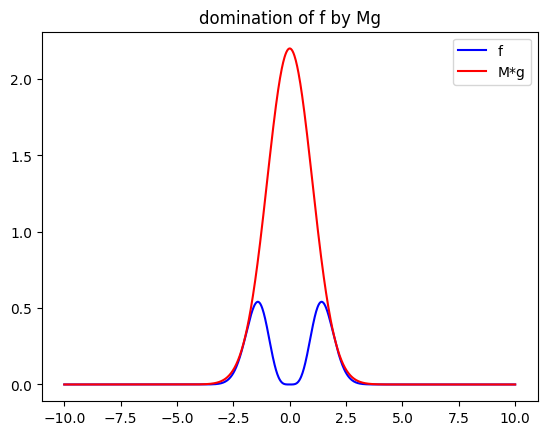

In [223]:
x = np.linspace(-10, 10, 1000)
f = lambda x: np.exp(- x ** 2) * x ** 4
g = lambda x: np.exp(- 0.5 * x ** 2)


M = 2.2

print("M =", M)

plt.title("domination of f by Mg")
plt.plot(x, f(x), color='blue', label='f')
plt.plot(x, M*g(x), color='red', label='M*g')
plt.legend()
plt.show()

2. Implement the rejection sampling algorithm and visualize the empirical histogram against the density f. Use scipy.integration to estimate the normalizing constant of f for accurate visualization of the density.

In [224]:
def rejection_sampling(N, f, g, M):
    """Reject sampling algorithm for f with Gaussian proposal g."""
    f_approx = []
    

    # on adapte M aux constantes de normalisation, nécessaire à la visualisation de f 
    G, _ = integr.quad(g, -np.inf, np.inf)
    F, _ = integr.quad(f, -np.inf, np.inf)
    print("constantes de normalisation: G =", G, "F =", F)
    
    # densités 
    x = np.random.normal(size=N)
    f_val, f_norm = f(x), f(x) / F
    g_val = g(x)
    g_norm = g_val / G
    

    # densités avant normalisation, suffisante pour faire le reject sampling     
    u = np.random.uniform(0, 1, N)

    for i in range(N):
        if (u[i] <= f_val[i] / (M*g_val[i])): # we accept the sample
            f_approx.append(x[i])
            
    print("nbre dechantillon retenus",len(f_approx))
    x_val = np.linspace(-5, 5, N)
    plt.plot(x_val, f(x_val)/F, color='blue', label='f')
    plt.plot(x_val, M*(G/F)*g(x_val)/G, color='red', label='M*g')
    #plt.plot(x, f_norm, color='blue', label='f', alpha=0.3)
    #plt.plot(x, M*g_norm, color='red', label='M*g', alpha=0.3)
    plt.hist(f_approx, bins=100, density=True, alpha=1, label='Empirical Histogram', color='green')
    plt.title('Empirical histogram computed with rejection sampling')
    plt.legend()
    plt.show()


constantes de normalisation: G = 2.5066282746309994 F = 1.3293403881791368
nbre dechantillon retenus 2386


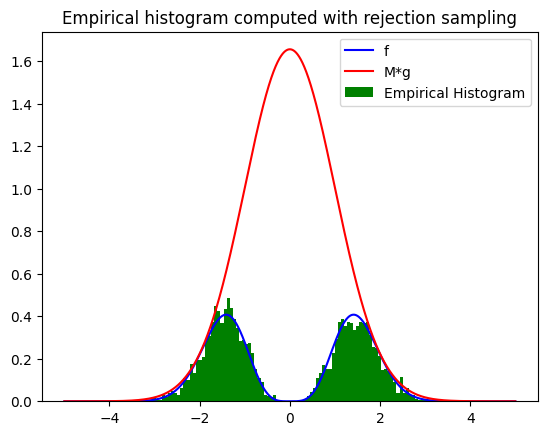

In [225]:
rejection_sampling(N=10000, f=f, g=g, M=2.2)

3. Implement the random walk metropolis hastings algorithm with a Gaussian conditional probability and visualize the empirical histogram against the normalized density f/F

In [226]:
def rw_metropolis_hastings(n, f=f, seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g.
    n: int.
        number of samples.
    f: callable. 
        density we want to sample from.
    seed: int (optional).
        random seed initialization.
    """

    sigma = 1.0 # standard deviation of the Gaussian proposal distribution

    if seed is not None:
        np.random.seed(seed)
    
    samples = np.zeros(n) # our random walk
    samples[0] = np.random.normal(0, 1)  # starting point
    
    for i in range(1, n):
        current = samples[i-1]
        proposal = np.random.normal(current, sigma) # on simule selon la normale 
        
        # Calculate acceptance probability
        accept_prob = f(proposal) / f(current)
        
        # Accept or reject the proposal
        if np.random.rand() < accept_prob:
            samples[i] = proposal
        else:
            samples[i] = current
    
    return samples




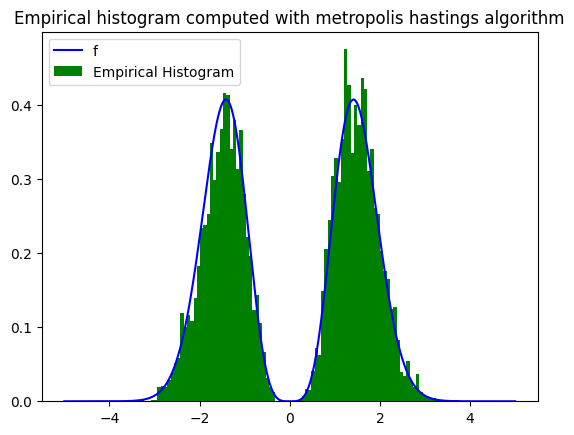

In [227]:
# Visualisation
n = 10000 # nombre d'échantillons à générer
f_hastings = rw_metropolis_hastings(n)

x_val = np.linspace(-5, 5, n)
F, _ = integr.quad(f, -np.inf, np.inf)

plt.plot(x_val, f(x_val)/F, color='blue', label='f')
#plt.plot(x_val, M*(G/F)*g(x_val)/G, color='red', label='M*g')
plt.hist(f_hastings, bins=100, density=True, alpha=1, label='Empirical Histogram', color='green')
plt.title('Empirical histogram computed with metropolis hastings algorithm')
plt.legend()
plt.show()

# II - Gibbs sampling
Gibbs sampling is a Markov Chain sampling algorithm used to sample from a multivariate random variable by sampling each component from its conditional distribution while the others components are fixed.

We would like to sample from a multivariate Gaussian $(X_1, X_2)$ with density:
$$p(x_1, x_2) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)\right) $$
*1. Identify the parameters of the distribution and compute the conditional distributions of each component.*

$$Cov=\begin{pmatrix}
1 & \rho \\
\rho & 1
\end{pmatrix}$$
$$\mu= \begin{pmatrix}
0 \\
0 
\end{pmatrix}$$

$$X_1 | X_2 \sim \mathcal{N}(\rho X_2 , 1-p^2)$$
$$X_2 | X_1 \sim \mathcal{N}(\rho X_1 , 1-p^2)$$

We consider a Markov chain with a transition kernel $P(x, \cdot) \sim \mathcal{N}(\rho x, 1-p^2)$. At each step, we generate two samples, denoted as $X_1$ and $X_2$.

*2. Implement the associated Gibbs sampler where each $X_1, X_2$ are sampled sequentially from the conditional distributions.*

In [228]:
def gibbs_sampler(n,rho):
    """Gibbs sampler for (X_1, X_2)."""
    X=[]
    x,y=0,0
    for _ in range(n):
        x = np.random.normal(rho*y, np.sqrt(1-rho**2))
        y = np.random.normal(rho*x, np.sqrt(1-rho**2))
        X.append((x,y))
    return np.array(X)

3. Visualize the contour plots of the target distribution and that of the Gibbs Sampler for different values of n. How does it behave with $\rho$ ?

First the target density:

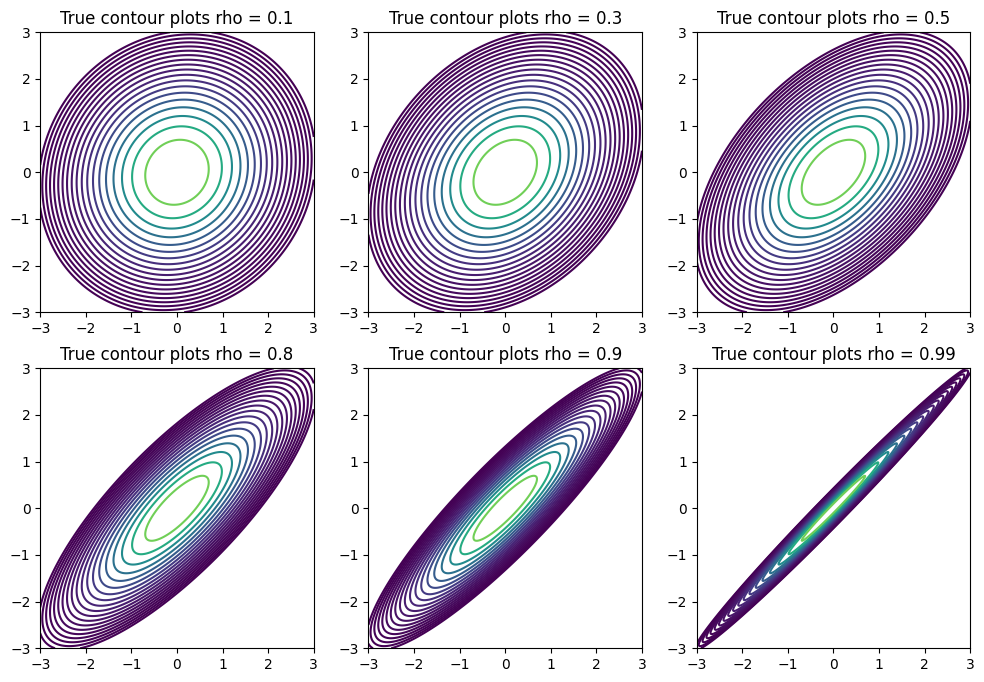

In [229]:
from scipy.stats import multivariate_normal
rho_array = [ 0.1, 0.3, 0.5, 0.8, 0.9, 0.99]

fig, ax = plt.subplots(2,3 , figsize=(12,8))
for i in range(len(rho_array)):
    rho=rho_array[i]
    S = np.array([[1, rho], [rho, 1]])
    grid = np.linspace(-3, 3, 1000)
    x, y = np.meshgrid(grid, grid)
    pos = np.empty((1000, 1000, 2))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
    ax[i//3][i%3].contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
    ax[i//3][i%3].set_title("True contour plots rho = " + str(rho))
plt.show()

Now we plot the contour plots as the Markov chain moves. Keep in mind that the Markov chain samples are correlated and therefore not iid ! We need to wait a whiler until the MC reaches the stationary distribution. We show this in the following plots:
First we plot everything till a certain iteration:

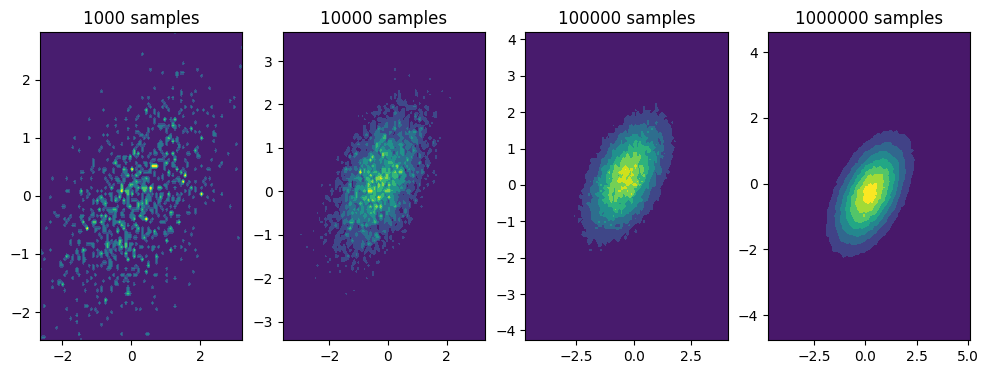

In [255]:
rho=0.5

fig, axs = plt.subplots(1,4, figsize=(12,4))
N_array = [10**k for k in range(3,7)]

for i in range(4):
    X = gibbs_sampler(N_array[i], rho)
    h, xedges, yedges = np.histogram2d(X[:,0], X[:,1], bins=100, density=True)
    x, y = np.meshgrid(xedges[:-1], yedges[:-1])
    axs[i].contourf(x,y,h,vmin=0,vmax=h.max())
    axs[i].set_title(str(N_array[i]) + " samples")
plt.show()

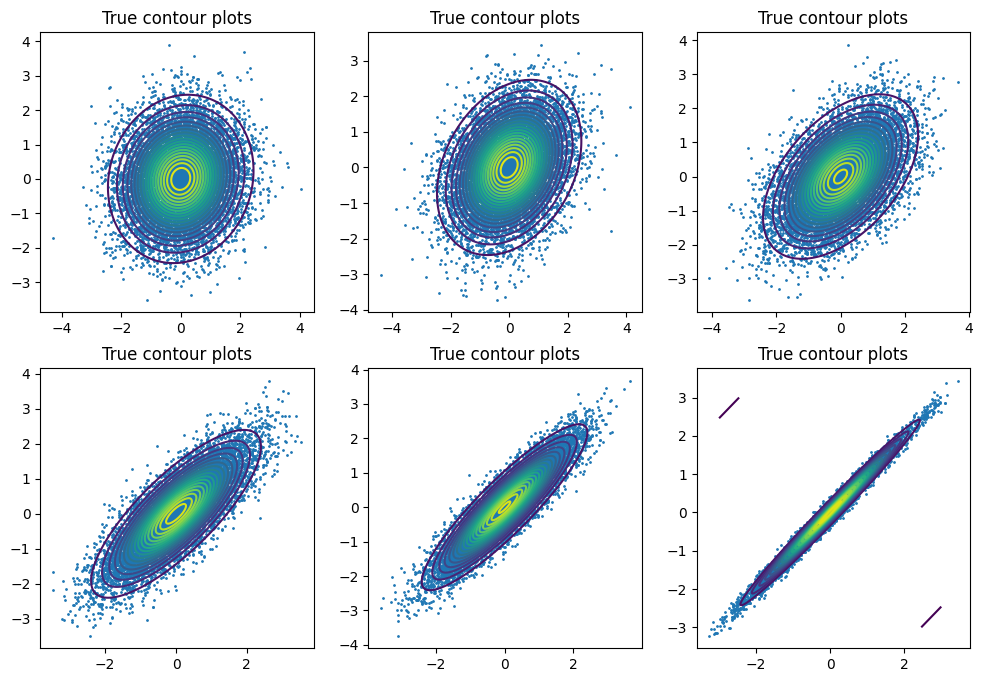

In [257]:
fig, axs = plt.subplots(2,3, figsize=(12,8))
print('[            ]' + str(0)[:4], end='\r')
rho_array = [ 0.1, 0.3, 0.5, 0.8, 0.9, 0.99]
for i in range(len(rho_array)):
    rho=rho_array[i]
    S = np.array([[1, rho], [rho, 1]])
    grid = np.linspace(-3, 3, 1000)
    x, y = np.meshgrid(grid, grid)
    pos = np.empty((1000, 1000, 2))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
    axs[i//3][i%3].contour(x, y, Z_true, levels=20)
    axs[i//3][i%3].set_title("True contour plots")
    X = gibbs_sampler(10000, rho)
    h, xedges, yedges = np.histogram2d(X[:,0], X[:,1], bins=100, density=True)
    x, y = X[:,0],X[:,1]
    axs[i//3][i%3].scatter(x,y,s=1)
    print('['+(i+1)*'||'+'  '*(5-i)+']' + str(int((i+1)*100)/600)[:4] + '     ', end='\r')
print('                          ', end='\r')
plt.show()


The MCMC method looks great

4. Using the numpy corrcoef function, plot the auto-correlation values as a function of the lag: $corr(X_t, X_{t - lag})$

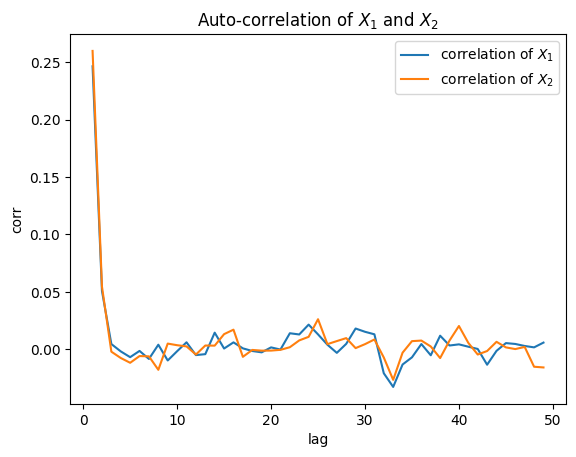

In [232]:
X=gibbs_sampler(10000,0.5)
x=X[:,0]
y=X[:,1]
# auto-correlation functiion as a function of the lag using numpy.corrcoef
def corr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

# parameters
N = 100_000
rho = 0.5

lag = np.arange(1, 50, 1)
autocorr_1 = [corr(x, t=t0)[0][1] for t0 in lag]
autocorr_2 = [corr(y, t=t0)[0][1] for t0 in lag]

# plotting the auto-correlation function
plt.figure()
plt.plot(lag, autocorr_1, label='correlation of $X_1$')
plt.plot(lag, autocorr_2, label='correlation of $X_2$')
plt.xlabel('lag')
plt.ylabel('corr')
plt.legend()
plt.title("Auto-correlation of $X_1$ and $X_2$")
plt.show()

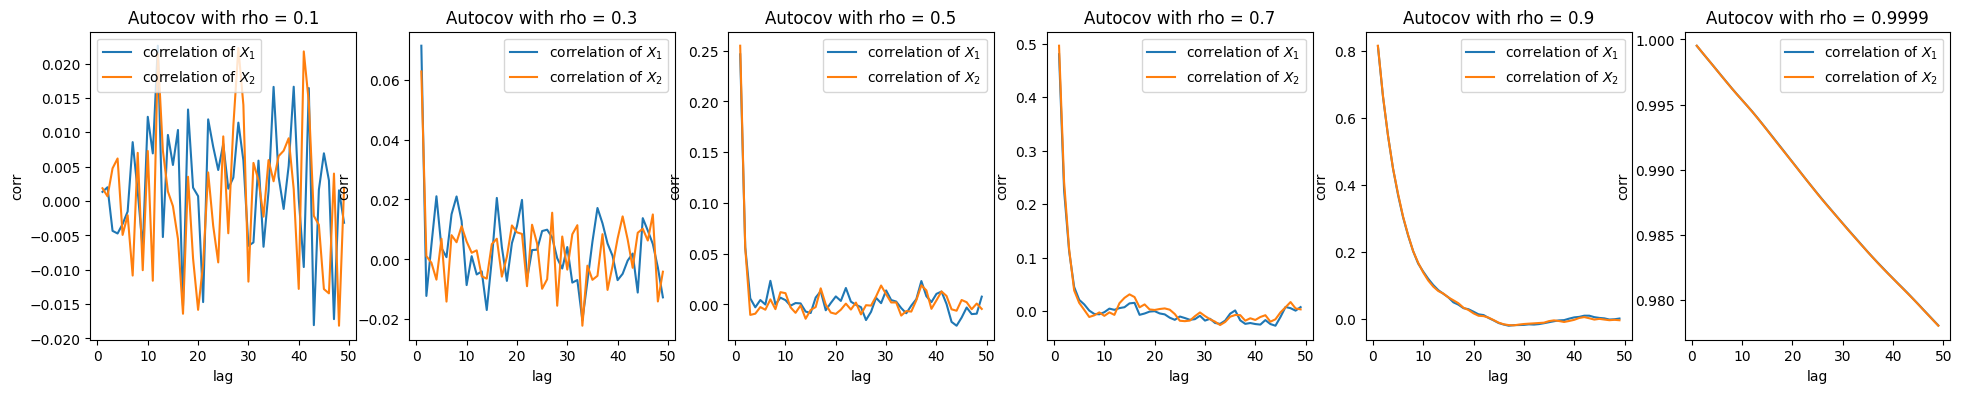

In [233]:
rho_array=[0.1,0.3,0.5,0.7,0.9,0.9999]
fig,axs=plt.subplots(1,6,figsize=(24,4))
for i in range(len(rho_array)):
    rho=rho_array[i]
    X=gibbs_sampler(10000,rho)
    x=X[:,0]
    y=X[:,1]
# auto-correlation functiion as a function of the lag using numpy.corrcoef

# parameters

    lag = np.arange(1, 50, 1)
    autocorr_1 = [corr(x, t=t0)[0][1] for t0 in lag]
    autocorr_2 = [corr(y, t=t0)[0][1] for t0 in lag]

# plotting the auto-correlation function
    axs[i].plot(lag, autocorr_1, label='correlation of $X_1$')
    axs[i].plot(lag, autocorr_2, label='correlation of $X_2$')
    axs[i].set_xlabel('lag')
    axs[i].set_ylabel('corr')
    axs[i].legend()
    axs[i].set_title("Autocov with rho = " + str(rho))
plt.show()

5. Using what you observe, propose two arguments to add to your Gibbs sampler function to improve the simulation.
What happens when $\rho \to 1$ ?

To enhance the simulation, we can introduce independent variables. With $\rho=0.5$ for $lag=3$, the autocovariance approaches zero, suggesting that every third value yields independent and identically distributed (iid) variables. $$ $$Additionally, we observe that the number of steps is a non-decreasing function of $p$. $$ $$
The second upgrade involves using a starting number, as the initial ones aren't relevant

In [238]:
def gibbs_sampler_upgrade(n, rho, T=1, s=0):
    X=[]
    x,y=0,0
    for _ in range(s):
        x= np.random.normal(rho*y, np.sqrt(1-rho**2))
        y=np.random.normal(rho*x, np.sqrt(1-rho**2))
    for _ in range(n):
        for _ in range(T):
            x= np.random.normal(rho*y, np.sqrt(1-rho**2))
            y=np.random.normal(rho*x, np.sqrt(1-rho**2))
        X.append((x,y))
    return np.array(X)

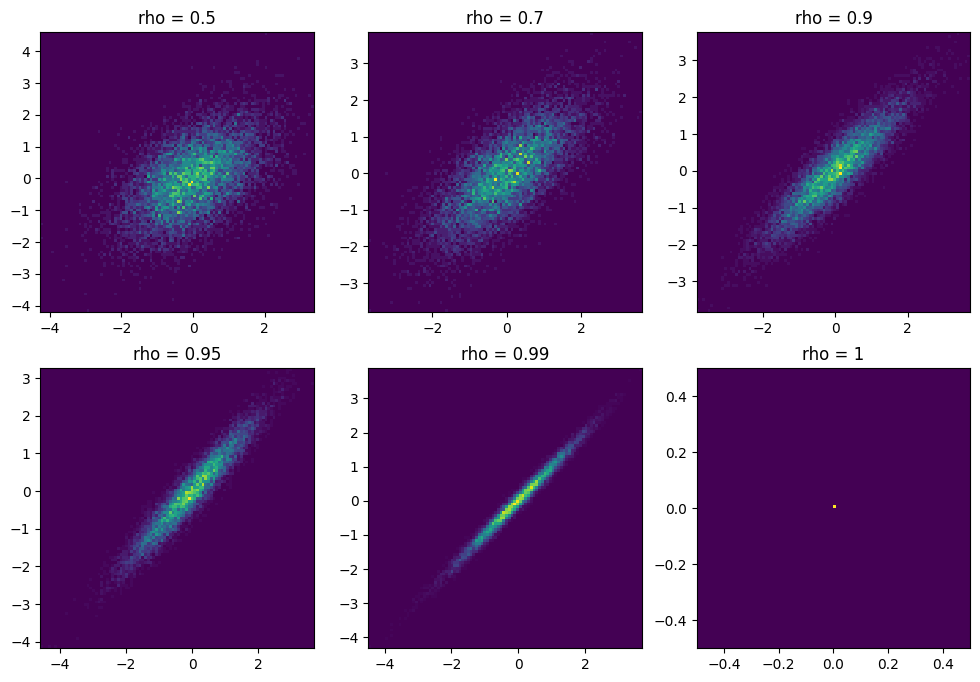

In [235]:
# plot the 2D histogram to see the evolution of the Gibbs sampler with rho
N = 10000
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
rho_array = [0.5, 0.7, 0.9 ,0.95, 0.99, 1]

for i in range(len(rho_array)):
    rho=rho_array[i]
    X = gibbs_sampler_upgrade(N, rho,10,2)
    x = X[:,0]
    y = X[:,1]
    ax[i//3][i%3].hist2d(x, y, bins=100, density=True)
    ax[i//3][i%3].set_title(f"rho = {rho}")
plt.show()


With these six plots, we observe that for $\rho$ close to one, the distribution is equivalent to a Dirac delta function at $(0,0)$, indicating high correlation among all values, as expected in the preceding graphics.

6. Implement a Random Walk metropolis algorithm to simulate from p using a conditional proposal $\mathcal N(0, \tau I_2)$ and vary $\tau$. 

In [244]:
def rw_metropolis_hastings(n, f, tau=1., seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g."""
    if seed is not None:
        np.random.seed(seed)
    i = 0
    X = np.array([0, 0])
    out = []
    while i < n :
        nX = np.random.multivariate_normal(X, tau*np.identity(2))
        u = np.random.random()
        if u <= f(nX[0], nX[1])/f(X[0], X[1]):
            X = nX
            out.append(nX)
            i += 1
    return np.array(out)

In [242]:
rho = 0.5
def p(x1, x2):
    return np.exp(-(x1**2+x2**2-2*rho*x1*x2) / (2*(1-rho**2)))/(2*np.pi*np.sqrt(1-rho**2))

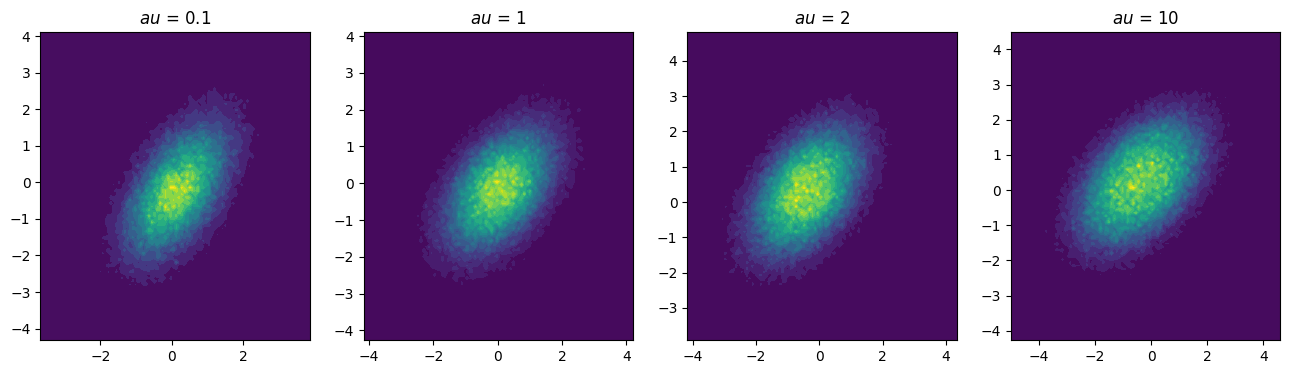

In [252]:
tau_array=[0.1,1,2,10]

fig,axs = plt.subplots(1,4,figsize=(16,4))
for i in range(len(tau_array)):
    tau=tau_array[i]
    X = rw_metropolis_hastings(100000,p,tau)
    h, xedges, yedges = np.histogram2d(X[:,0], X[:,1], bins=100, density=True)
    x, y = np.meshgrid(xedges[:-1], yedges[:-1])
    axs[i].contourf(x, y, h, vmin=0, vmax=h.max(), levels=20)
    axs[i].set_title("$\tau$ = " +str(tau))
plt.show()


If $\tau$ is too small, at each step we don't move enough so it takes more time to converge to the right distriubution and the first samples are not really meaningfull. $$ $$
If $\tau$ is too big, at each step we move too much so only few samples are accepted. $$ $$
So $\tau = 1$ seems to be a good compromise.